<a href="https://colab.research.google.com/github/FurqanBhat/Physics-Informed-Neural-Networks-PINNs-/blob/main/PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [66]:
#Generate synthetic data

g = -9.8
h0 = 1.0
v0 = 10.0

def true_solution(t):
  #h-h0=ut+1/2at^2
  return h0 + v0*t + 0.5*g*(t**2)

t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)


np.random.seed(1891)
noise_level=0.9
h_data_exact=true_solution(t_data)
h_data_noisy=h_data_exact+noise_level*np.random.randn(N_data)


#convert to pytorch
t_data_tensor=torch.tensor(t_data, dtype=torch.float32).view(-1,1)
h_data_tensor=torch.tensor(h_data_noisy, dtype=torch.float32).view(-1,1)

In [67]:
t_data

array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ])

In [68]:
h_data_exact

array([1.        , 2.98024691, 4.47654321, 5.48888889, 6.01728395,
       6.0617284 , 5.62222222, 4.69876543, 3.29135802, 1.4       ])

In [69]:
h_data_noisy

array([0.62978132, 2.54978629, 5.84582727, 3.35588011, 5.66919036,
       6.56011991, 5.58807012, 5.13920272, 2.6775743 , 0.85904637])

In [70]:
def derivative(y, x):
  return torch.autograd.grad(
      y,x,
      grad_outputs=torch.ones_like(y),
      create_graph=True
  )[0]

In [71]:
class PINN(nn.Module):
  def __init__(self, n_hidden=20):
    super().__init__()
    #Hidden layers with 20 nodes
    self.net = nn.Sequential(
        nn.Linear(1, n_hidden),
        nn.Tanh(),
        nn.Linear(n_hidden, n_hidden),
        nn.Tanh(),
        nn.Linear(n_hidden, 1)
    )

  def forward(self, t):
    return self.net(t)

In [72]:
def physics_loss(model, t):
  #dh_dt_pred=v0+at
  t.requires_grad_(True)
  h_pred = model(t)
  dh_dt_pred = derivative(h_pred, t)
  dh_dt_true = v0+g*t

  loss_ode = torch.mean((dh_dt_true-dh_dt_pred)**2)
  return loss_ode


In [73]:
def initial_condition_loss(model):
    t0 = torch.zeros((1, 1), dtype=torch.float32)

    h0_pred = model(t0)

    loss = torch.mean((h0 - h0_pred)**2)
    return loss


In [74]:
def data_loss(model, t_data, h_data):
  h_pred = model(t_data)

  loss = torch.mean((h_pred-h_data)**2)

  return loss


In [75]:
model1=PINN()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

lambda_data = 1.0
lambda_ode = 1.0
lambda_ic = 1.0

num_epochs = 1000
print_every = 200

In [76]:
model1.train()
for epoch in range(num_epochs):
  optimizer.zero_grad()

  d_loss = data_loss(model1, t_data_tensor, h_data_tensor)
  ode_loss = physics_loss(model1, t_data_tensor)
  ic_loss = initial_condition_loss(model1)

  loss = lambda_data*d_loss + lambda_ode*ode_loss + lambda_ic*ic_loss

  loss.backward()
  optimizer.step()

  if (epoch+1)%print_every == 0:
    print(
        f"Epoch {epoch+1}/{num_epochs}",
        f"Total Loss: {loss.item():.6f}",
        f"Data Loss: {d_loss.item():.6f}",
        f"Physics Loss: {ode_loss.item():.6f}",
        f"Initial Condition Loss: {ic_loss.item():.6f}"
    )

Epoch 200/1000 Total Loss: 0.774802 Data Loss: 0.750087 Physics Loss: 0.018395 Initial Condition Loss: 0.006320
Epoch 400/1000 Total Loss: 0.755307 Data Loss: 0.737324 Physics Loss: 0.014150 Initial Condition Loss: 0.003834
Epoch 600/1000 Total Loss: 0.740580 Data Loss: 0.728029 Physics Loss: 0.010328 Initial Condition Loss: 0.002223
Epoch 800/1000 Total Loss: 0.729777 Data Loss: 0.718269 Physics Loss: 0.010350 Initial Condition Loss: 0.001158
Epoch 1000/1000 Total Loss: 0.713044 Data Loss: 0.702112 Physics Loss: 0.009871 Initial Condition Loss: 0.001061


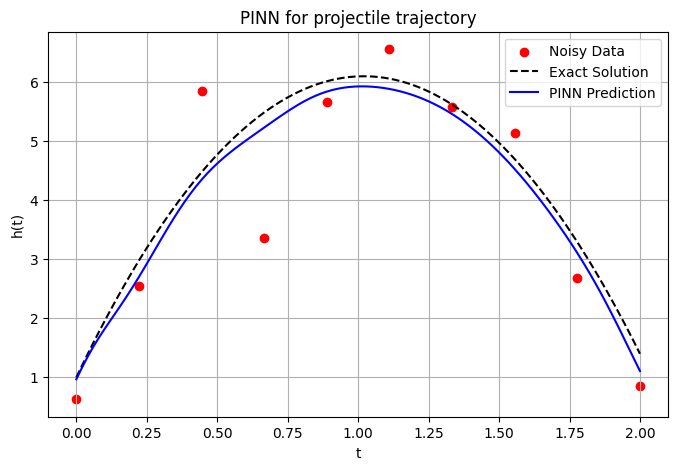

In [77]:
#EVALUATE
model1.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot)

with torch.no_grad():
  h_pred_plot = model1(t_plot_tensor).numpy()

h_true_plot = true_solution(t_plot)


plt.figure(figsize=(8,5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')

plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for projectile trajectory')
plt.grid(True)
plt.show()

In [78]:
#Model with no physics information
model2=PINN()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

lambda_data = 2.0
lambda_ode = 0.0
lambda_ic = 0.0

num_epochs = 1000
print_every = 200

In [79]:
model2.train()
for epoch in range(num_epochs):
  optimizer2.zero_grad()

  d_loss = data_loss(model2, t_data_tensor, h_data_tensor)
  ode_loss = physics_loss(model2, t_data_tensor)
  ic_loss = initial_condition_loss(model2)

  loss = lambda_data*d_loss + lambda_ode*ode_loss + lambda_ic*ic_loss

  loss.backward()
  optimizer2.step()

  if (epoch+1)%print_every == 0:
    print(
        f"Epoch {epoch+1}/{num_epochs}",
        f"Total Loss: {loss.item():.6f}",
        f"Data Loss: {d_loss.item():.6f}",
        f"Physics Loss: {ode_loss.item():.6f}",
        f"Initial Condition Loss: {ic_loss.item():.6f}"
    )

Epoch 200/1000 Total Loss: 3.358981 Data Loss: 1.679491 Physics Loss: 14.821442 Initial Condition Loss: 0.140021
Epoch 400/1000 Total Loss: 1.223047 Data Loss: 0.611524 Physics Loss: 27.927485 Initial Condition Loss: 0.141542
Epoch 600/1000 Total Loss: 0.728581 Data Loss: 0.364291 Physics Loss: 40.127922 Initial Condition Loss: 0.259604
Epoch 800/1000 Total Loss: 0.092142 Data Loss: 0.046071 Physics Loss: 40.366211 Initial Condition Loss: 0.132538
Epoch 1000/1000 Total Loss: 0.075846 Data Loss: 0.037923 Physics Loss: 42.386238 Initial Condition Loss: 0.134643


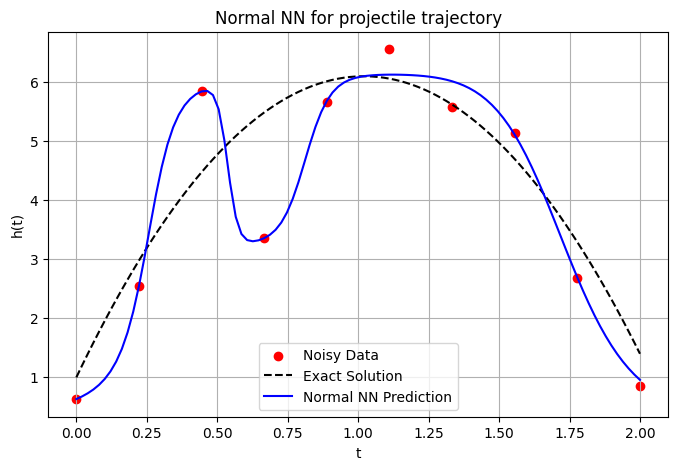

In [80]:
#EVALUATE
model2.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot)

with torch.no_grad():
  h_pred_plot = model2(t_plot_tensor).numpy()

h_true_plot = true_solution(t_plot)


plt.figure(figsize=(8,5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='Normal NN Prediction')

plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('Normal NN for projectile trajectory')
plt.grid(True)
plt.show()

Comparing Normal Neural Networks vs PINNs


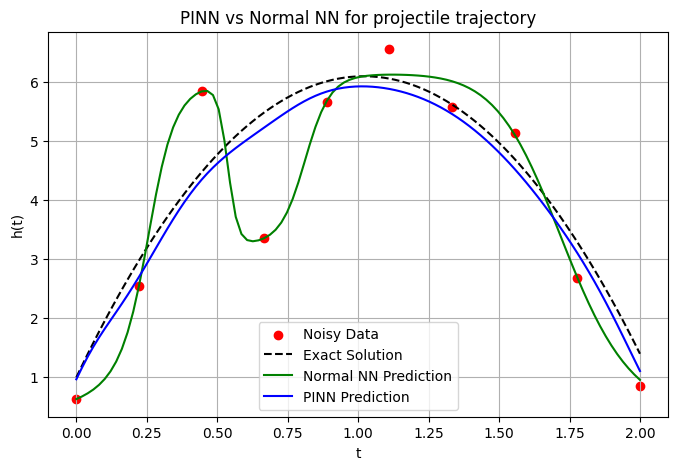

In [81]:
# EVALUATE BOTH MODELS
model1.eval()
model2.eval()

t_plot = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot)

with torch.no_grad():
    h_pred_pinn = model1(t_plot_tensor).numpy()
    h_pred_nn   = model2(t_plot_tensor).numpy()

h_true_plot = true_solution(t_plot)

# COMBINED PLOT
plt.figure(figsize=(8,5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')

plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_nn, 'g', label='Normal NN Prediction')
plt.plot(t_plot, h_pred_pinn, 'b', label='PINN Prediction')

plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN vs Normal NN for projectile trajectory')
plt.grid(True)
plt.show()
